### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
# Reproducibility
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

### Load Data

In [2]:
df_ratings = pd.read_csv('ml-100k/ml-latest-small/ratings.csv')
df_tags = pd.read_csv('ml-100k/ml-latest-small/tags.csv')
df_movies = pd.read_csv('ml-100k/ml-latest-small/movies.csv')

In [3]:
df_rating_tags = pd.merge(df_ratings, df_tags, on=['userId', 'movieId'], how='inner')
df_final = pd.merge(df_rating_tags, df_movies, on=['movieId'], how='inner')
df_final.drop(columns=['timestamp_x', 'timestamp_y'], inplace=True)

In [4]:
df_final.head(8)

,userId,movieId,rating,tag,title,genres
0,2,60756,5.0,funny,Step Brothers (2008),Comedy
1,2,60756,5.0,Highly quotable,Step Brothers (2008),Comedy
2,2,60756,5.0,will ferrell,Step Brothers (2008),Comedy
3,2,89774,5.0,Boxing story,Warrior (2011),Drama
4,2,89774,5.0,MMA,Warrior (2011),Drama
5,2,89774,5.0,Tom Hardy,Warrior (2011),Drama
6,2,106782,5.0,drugs,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
7,2,106782,5.0,Leonardo DiCaprio,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama


### EDA

In [5]:
print(f'Banyak data : {df_final.shape[0]}')
print(f'Banyak atribut : {df_final.shape[1]}')

Banyak data : 3476
Banyak atribut : 6


In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476 entries, 0 to 3475
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   3476 non-null   int64  
 1   movieId  3476 non-null   int64  
 2   rating   3476 non-null   float64
 3   tag      3476 non-null   object 
 4   title    3476 non-null   object 
 5   genres   3476 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 163.1+ KB


In [7]:
df_final.isnull().sum()

userId     0
movieId    0
rating     0
tag        0
title      0
genres     0
dtype: int64

In [8]:
df_final.duplicated().sum()

0

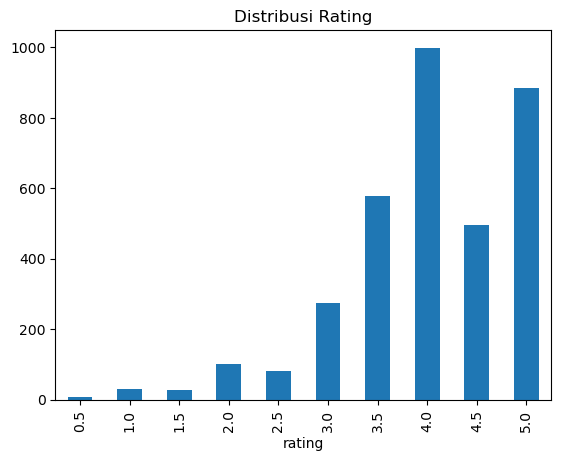

In [9]:
df_final['rating'].value_counts().sort_index().plot(kind='bar', title='Distribusi Rating')
plt.show()

<Axes: title={'center': 'Frekuensi Genre'}>

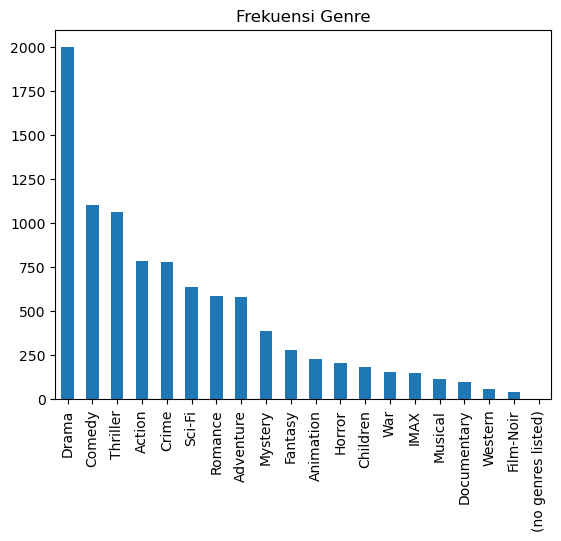

In [10]:
from collections import Counter

genre_counts = Counter()
df_final['genres'].str.split('|').apply(genre_counts.update)
pd.Series(genre_counts).sort_values(ascending=False).plot(kind='bar', title='Frekuensi Genre')

### Data Preparation

In [11]:
df_final.head(10)

,userId,movieId,rating,tag,title,genres
0,2,60756,5.0,funny,Step Brothers (2008),Comedy
1,2,60756,5.0,Highly quotable,Step Brothers (2008),Comedy
2,2,60756,5.0,will ferrell,Step Brothers (2008),Comedy
3,2,89774,5.0,Boxing story,Warrior (2011),Drama
4,2,89774,5.0,MMA,Warrior (2011),Drama
5,2,89774,5.0,Tom Hardy,Warrior (2011),Drama
6,2,106782,5.0,drugs,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
7,2,106782,5.0,Leonardo DiCaprio,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
8,2,106782,5.0,Martin Scorsese,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
9,7,48516,1.0,way too long,"Departed, The (2006)",Crime|Drama|Thriller


In [12]:
df_final_content_based = df_final.groupby('title').agg({
    'genres': 'first',  # atau pakai mode/first
    'tag': lambda x: ' '.join(set(x))  # gabung tag unik
}).reset_index()

In [13]:
df_final_content_based['genres_clean'] = df_final_content_based['genres'].str.replace('|', ' ', regex=False)

In [14]:
df_final_content_based['content_based_features'] = df_final_content_based['genres_clean'].str.lower() + ' ' + df_final_content_based['tag'].str.lower()

In [15]:
df_final_content_based

,title,genres,tag,genres_clean,content_based_features
0,(500) Days of Summer (2009),Comedy|Drama|Romance,Zooey Deschanel humorous artistic intelligent ...,Comedy Drama Romance,comedy drama romance zooey deschanel humorous ...
1,...And Justice for All (1979),Drama|Thriller,lawyers,Drama Thriller,drama thriller lawyers
2,10 Cloverfield Lane (2016),Thriller,suspense creepy,Thriller,thriller suspense creepy
3,10 Things I Hate About You (1999),Comedy|Romance,Shakespeare sort of,Comedy Romance,comedy romance shakespeare sort of
4,101 Dalmatians (1996),Adventure|Children|Comedy,dogs remake,Adventure Children Comedy,adventure children comedy dogs remake
...,...,...,...,...,...
1459,Zero Dark Thirty (2012),Action|Drama|Thriller,American propaganda terrorism military Afghani...,Action Drama Thriller,action drama thriller american propaganda terr...
1460,Zombieland (2009),Action|Comedy|Horror,Jesse Eisenberg funny dark comedy Woody Harrel...,Action Comedy Horror,action comedy horror jesse eisenberg funny dar...
1461,Zoolander (2001),Comedy,goofy David Bowie mindless one liners ben stil...,Comedy,comedy goofy david bowie mindless one liners b...
1462,Zulu (1964),Action|Drama|War,Africa,Action Drama War,action drama war africa


In [16]:
df_final_collaborative = df_final[['userId','movieId','rating','genres','tag']]

In [17]:
df_final_collaborative

,userId,movieId,rating,genres,tag
0,2,60756,5.0,Comedy,funny
1,2,60756,5.0,Comedy,Highly quotable
2,2,60756,5.0,Comedy,will ferrell
3,2,89774,5.0,Drama,Boxing story
4,2,89774,5.0,Drama,MMA
...,...,...,...,...,...
3471,606,6107,4.0,Drama|War,World War II
3472,606,7382,4.5,Drama|Mystery|Thriller,for katie
3473,610,3265,5.0,Action|Crime|Drama|Thriller,gun fu
3474,610,3265,5.0,Action|Crime|Drama|Thriller,heroic bloodshed


In [18]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df_final_collaborative['userId'].unique().tolist()
print('list userID: ', user_ids)
 
# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [2, 7, 18, 21, 49, 62, 63, 76, 103, 106, 112, 119, 125, 132, 138, 161, 166, 167, 177, 184, 193, 205, 226, 256, 274, 289, 291, 300, 305, 318, 319, 327, 336, 356, 357, 419, 424, 435, 439, 462, 474, 477, 487, 506, 509, 513, 520, 533, 537, 567, 573, 599, 606, 610]
encoded userID :  {2: 0, 7: 1, 18: 2, 21: 3, 49: 4, 62: 5, 63: 6, 76: 7, 103: 8, 106: 9, 112: 10, 119: 11, 125: 12, 132: 13, 138: 14, 161: 15, 166: 16, 167: 17, 177: 18, 184: 19, 193: 20, 205: 21, 226: 22, 256: 23, 274: 24, 289: 25, 291: 26, 300: 27, 305: 28, 318: 29, 319: 30, 327: 31, 336: 32, 356: 33, 357: 34, 419: 35, 424: 36, 435: 37, 439: 38, 462: 39, 474: 40, 477: 41, 487: 42, 506: 43, 509: 44, 513: 45, 520: 46, 533: 47, 537: 48, 567: 49, 573: 50, 599: 51, 606: 52, 610: 53}
encoded angka ke userID:  {0: 2, 1: 7, 2: 18, 3: 21, 4: 49, 5: 62, 6: 63, 7: 76, 8: 103, 9: 106, 10: 112, 11: 119, 12: 125, 13: 132, 14: 138, 15: 161, 16: 166, 17: 167, 18: 177, 19: 184, 20: 193, 21: 205, 22: 226, 23: 256, 24: 274, 25: 289,

In [19]:
# Mengubah userID menjadi list tanpa nilai yang sama
movie_ids = df_final_collaborative['movieId'].unique().tolist()
print('list movieId: ', movie_ids)
 
# Melakukan encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print('encoded movieId : ', movie_to_movie_encoded)
 
# Melakukan proses encoding angka ke ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
print('encoded angka ke movieId: ', movie_encoded_to_movie)

list movieId:  [60756, 89774, 106782, 48516, 431, 1221, 5995, 44665, 52604, 88094, 144210, 119141, 109487, 2, 110, 410, 2023, 2124, 2953, 3114, 3578, 4223, 5388, 6058, 6534, 6541, 6564, 7153, 8641, 27660, 27706, 27808, 27831, 31658, 33162, 34150, 37729, 38061, 45447, 46723, 46972, 46976, 49130, 49530, 53464, 58047, 59501, 60074, 60126, 61024, 63992, 68848, 71535, 87430, 88405, 96861, 99114, 103042, 104863, 107348, 108190, 111743, 114180, 115149, 116897, 122912, 128360, 135133, 135518, 135536, 136864, 139385, 158966, 168248, 174053, 179401, 183611, 184471, 187593, 187595, 260, 296, 4896, 106489, 101142, 115617, 120635, 1726, 2387, 3052, 5088, 7022, 7254, 8957, 9010, 42632, 58301, 60950, 62434, 67695, 100083, 156371, 158872, 3556, 6323, 6367, 59103, 52287, 293, 54286, 104, 2579, 3793, 4226, 6283, 27156, 193565, 4878, 7147, 97938, 6938, 48780, 126548, 68319, 3, 1101, 50872, 102007, 118696, 6711, 4034, 4995, 6502, 6953, 34405, 55721, 83134, 778, 4612, 4708, 64034, 68954, 71494, 81158, 8245

In [20]:
# Mapping userID ke dataframe user
df_final_collaborative['user_encoded'] = df_final_collaborative['userId'].map(user_to_user_encoded)

In [21]:
df_final_collaborative['movie_encoded'] = df_final_collaborative['movieId'].map(movie_to_movie_encoded) 

In [22]:
df_final_collaborative['rating']=df_final_collaborative['rating'].values.astype(np.float64)

In [23]:
df_final_collaborative = df_final_collaborative.sample(frac=1, random_state=42)
df_final_collaborative.head(5)

,userId,movieId,rating,genres,tag,user_encoded,movie_encoded
2069,474,6852,3.5,Crime|Drama,death penalty,40,1129
1425,474,1942,3.5,Drama,Robert Penn Warren,40,627
309,62,122912,4.0,Action|Adventure|Sci-Fi,Marvel,5,65
2270,474,30812,4.0,Drama,Howard Hughes,40,1291
3037,567,113705,3.5,Drama,bittersweet,49,1419


### Model Development Content Based Filtering

In [24]:
df_final_content_based.head(5)

,title,genres,tag,genres_clean,content_based_features
0,(500) Days of Summer (2009),Comedy|Drama|Romance,Zooey Deschanel humorous artistic intelligent ...,Comedy Drama Romance,comedy drama romance zooey deschanel humorous ...
1,...And Justice for All (1979),Drama|Thriller,lawyers,Drama Thriller,drama thriller lawyers
2,10 Cloverfield Lane (2016),Thriller,suspense creepy,Thriller,thriller suspense creepy
3,10 Things I Hate About You (1999),Comedy|Romance,Shakespeare sort of,Comedy Romance,comedy romance shakespeare sort of
4,101 Dalmatians (1996),Adventure|Children|Comedy,dogs remake,Adventure Children Comedy,adventure children comedy dogs remake


In [25]:
tf = TfidfVectorizer(analyzer='word',min_df=0.0, stop_words='english')

tf.fit(df_final_content_based['content_based_features'])

tf.get_feature_names_out()

array(['06', '1900s', '1920s', ..., 'zombie', 'zombies', 'zooey'],
      dtype=object)

In [26]:
tfidf_matrix = tf.fit_transform(df_final_content_based['content_based_features'])

tfidf_matrix.shape

(1464, 1646)

In [27]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_final_content_based['title'], columns=df_final_content_based['title'])

In [28]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=df_final_content_based.title
).sample(50, axis=1).sample(10, axis=0)

,heroin,vertriloquism,human,postmodern,satirical,bronte,tv,jim,roger,macho,...,bowie,disney,jeff,adoption,kirk,tedious,fbi,strangers,enterprise,winona
title,,,,,,,,,,,,,,,,,,,,,
Millennium Actress (Sennen joyû) (2001),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thor: Ragnarok (2017),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"American President, The (1995)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Elephant (2003),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road (1987),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Black Mirror: White Christmas (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Harry Potter and the Chamber of Secrets (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Broadcast News (1987),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Taken 2 (2012),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
cosine_sim_df.head(5)

title,(500) Days of Summer (2009),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),"11'09""01 - September 11 (2002)",12 Angry Men (1957),13 Going on 30 (2004),2001: A Space Odyssey (1968),...,Young Frankenstein (1974),Z (1969),Zack and Miri Make a Porno (2008),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zulu (1964),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),1.000000,0.018079,0.000000,0.091328,0.022123,0.000000,0.019878,0.005832,0.077686,0.002282,...,0.030480,0.017134,0.072032,0.109465,0.039053,0.007564,0.082323,0.022103,0.015741,0.000000
...And Justice for All (1979),0.018079,1.000000,0.114499,0.000000,0.000000,0.000000,0.053453,0.015683,0.000000,0.006136,...,0.000000,0.173587,0.025444,0.049983,0.000000,0.076633,0.000000,0.000000,0.042328,0.082185
10 Cloverfield Lane (2016),0.000000,0.114499,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.108517,0.000000,0.000000,0.000000,0.047906,0.000000,0.000000,0.000000,0.069942
10 Things I Hate About You (1999),0.091328,0.000000,0.000000,1.000000,0.045446,0.000000,0.000000,0.000000,0.100590,0.000000,...,0.062614,0.000000,0.081017,0.093344,0.080225,0.000000,0.042612,0.045406,0.000000,0.000000
101 Dalmatians (1996),0.022123,0.000000,0.000000,0.045446,1.000000,0.275811,0.000000,0.000000,0.038658,0.014964,...,0.058195,0.000000,0.031135,0.000000,0.074563,0.000000,0.039605,0.042202,0.000000,0.000000


In [30]:
def recommend_movies(title, cosine_sim_df=cosine_sim_df, top_n=5):
    if title not in cosine_sim_df.index:
        return f"Film '{title}' tidak ditemukan di dalam dataset."

    sim_scores = cosine_sim_df.loc[title]

    sim_scores = sim_scores.sort_values(ascending=False)
    return sim_scores.iloc[1:top_n+1]


In [31]:
cosine_sim_df.index = cosine_sim_df.index.astype(str)
cosine_sim_df.columns = cosine_sim_df.columns.astype(str)

In [32]:
result=recommend_movies("Sweet Charity (1969)", top_n=10)

In [33]:
def find_tag_genres(title):
    result=df_final_content_based[df_final_content_based.title==title]
    return (result[['title', 'content_based_features']])

In [34]:
find_tag_genres("Sweet Charity (1969)")

,title,content_based_features
1254,Sweet Charity (1969),comedy drama musical romance prostitution


In [35]:
result_df = pd.DataFrame()
for p in result.index:
    df = find_tag_genres(p)
    result_df = pd.concat([result_df, df], ignore_index=True)

In [36]:
result_df

,title,content_based_features
0,Gigi (1958),musical prostitution
1,Pretty Woman (1990),comedy romance prostitution
2,Risky Business (1983),comedy prostitution
3,Midnight Cowboy (1969),drama prostitution
4,Mighty Aphrodite (1995),comedy drama romance prostitution adoption
5,"Umbrellas of Cherbourg, The (Parapluies de Che...",drama musical romance made me cry
6,Lagaan: Once Upon a Time in India (2001),comedy drama musical romance india
7,White Christmas (1954),comedy musical romance christmas
8,Gentlemen Prefer Blondes (1953),comedy musical romance in netflix queue
9,"Gay Divorcee, The (1934)",comedy musical romance divorce


#### Evaluasi dengan Precision@10

Kita mengambil sampel untuk film "Sweet Charity (1969)" dengan genre+tag : comedy drama musical romance prostitution
Kita menentukan rekomendasi relevan dengan ketentuan :
Apabila terdapat minimal satu bagian dari genre atau tag yang sesuai, maka dianggap relevan.
Sehingga, utk K=10 rekomendasi, diperoleh ke 10 rekomendasi relevan.

In [37]:
precision10 = 10/10
print(f'precision@10 = ', precision10)

precision@10 =  1.0


### Model Development Collaborative Filtering

In [38]:
df_final_collaborative

,userId,movieId,rating,genres,tag,user_encoded,movie_encoded
2069,474,6852,3.5,Crime|Drama,death penalty,40,1129
1425,474,1942,3.5,Drama,Robert Penn Warren,40,627
309,62,122912,4.0,Action|Adventure|Sci-Fi,Marvel,5,65
2270,474,30812,4.0,Drama,Howard Hughes,40,1291
3037,567,113705,3.5,Drama,bittersweet,49,1419
...,...,...,...,...,...,...,...
1095,474,733,4.0,Action|Adventure|Thriller,Alcatraz,40,369
1130,474,919,4.5,Adventure|Children|Fantasy|Musical,Dorothy,40,402
1294,474,1254,4.5,Action|Adventure|Drama|Western,Cold,40,521
860,424,68157,4.5,Action|Drama|War,satire,36,225


In [39]:
min_rating = df_final_collaborative['rating'].min()
max_rating = df_final_collaborative['rating'].max()

In [40]:
x = df_final_collaborative[['user_encoded','movie_encoded']].values
y = df_final_collaborative['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [41]:
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * x.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[  40 1129]
 [  40  627]
 [   5   65]
 ...
 [  40  521]
 [  36  225]
 [  51  108]] [0.66666667 0.66666667 0.77777778 ... 0.88888889 0.88888889 1.        ]


In [42]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah resto
num_movies = len(movie_encoded_to_movie)
print(num_movies)

54
1464


In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(SEED)
class RecommenderNet(tf.keras.Model):
 
  # Inisialisasi model
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size

    # Layer embedding untuk user
    self.user_embedding = layers.Embedding(
        input_dim=num_users,
        output_dim=embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )

    # Layer bias untuk user
    self.user_bias = layers.Embedding(
        input_dim=num_users,
        output_dim=1
    )

    # Layer embedding untuk film
    self.movies_embedding = layers.Embedding(
        input_dim=num_movies,
        output_dim=embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )

    # Layer bias untuk film
    self.movies_bias = layers.Embedding(
        input_dim=num_movies,
        output_dim=1
    )
 
  # Proses forward (prediksi)
  def call(self, inputs):
    # Ambil vektor embedding dan bias berdasarkan user dan film
    user_vector = self.user_embedding(inputs[:, 0])       # vektor user
    user_bias = self.user_bias(inputs[:, 0])              # bias user
    movies_vector = self.movies_embedding(inputs[:, 1])   # vektor film
    movies_bias = self.movies_bias(inputs[:, 1])          # bias film

    # Hitung kecocokan (dot product) antara user dan film
    dot_user_movies = tf.tensordot(user_vector, movies_vector, axes=2)

    # Tambahkan bias
    x = dot_user_movies + user_bias + movies_bias
    
    # Aktivasi sigmoid untuk mengubah output ke rentang [0, 1]
    return tf.nn.sigmoid(x)


In [44]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [45]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 30,
    validation_data = (x_val, y_val)
)

Epoch 1/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6191 - root_mean_squared_error: 0.2793 - val_loss: 0.5347 - val_root_mean_squared_error: 0.1977
Epoch 2/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5217 - root_mean_squared_error: 0.1867 - val_loss: 0.5269 - val_root_mean_squared_error: 0.1922
Epoch 3/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5052 - root_mean_squared_error: 0.1716 - val_loss: 0.5196 - val_root_mean_squared_error: 0.1870
Epoch 4/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4957 - root_mean_squared_error: 0.1628 - val_loss: 0.5175 - val_root_mean_squared_error: 0.1865
Epoch 5/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4900 - root_mean_squared_error: 0.1576 - val_loss: 0.5137 - val_root_mean_squared_error: 0.1845
Epoch 6/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4864 - root_mean_squared_error: 0.1543 - val_loss: 0.5123 - val_root_mean_squared_error: 0.1840
Epoch 7/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

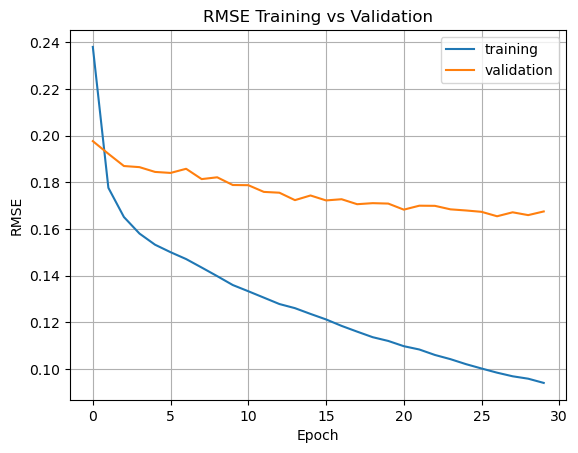

In [46]:
plt.plot(history.history['root_mean_squared_error'], label='training')
plt.plot(history.history['val_root_mean_squared_error'], label='validation')
plt.legend()
plt.title('RMSE Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel(('RMSE'))
plt.grid(True)
plt.show()

In [47]:
df_final

,userId,movieId,rating,tag,title,genres
0,2,60756,5.0,funny,Step Brothers (2008),Comedy
1,2,60756,5.0,Highly quotable,Step Brothers (2008),Comedy
2,2,60756,5.0,will ferrell,Step Brothers (2008),Comedy
3,2,89774,5.0,Boxing story,Warrior (2011),Drama
4,2,89774,5.0,MMA,Warrior (2011),Drama
...,...,...,...,...,...,...
3471,606,6107,4.0,World War II,Night of the Shooting Stars (Notte di San Lore...,Drama|War
3472,606,7382,4.5,for katie,I'm Not Scared (Io non ho paura) (2003),Drama|Mystery|Thriller
3473,610,3265,5.0,gun fu,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller
3474,610,3265,5.0,heroic bloodshed,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller


In [48]:
user_id = df_final.userId.sample(1).iloc[0]

In [49]:
movies_watched = df_final[df_final.userId == user_id]

In [50]:
movies_not_watched = df_final[~df_final['movieId'].isin(movies_watched.movieId.values)]['movieId']

In [51]:
movies_not_watched = list(
    set(movies_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

In [52]:
movies_not_watched = [[movie_to_movie_encoded.get(x)] for x in movies_not_watched]

In [53]:
user_encoder = user_to_user_encoded.get(user_id)

In [54]:
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

In [55]:
ratings = model.predict(user_movie_array).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [56]:
top_ratings_indices = ratings.argsort()[-10:][::-1]

In [57]:
top_ratings_indices

array([250,  38, 134, 235, 110, 123,  40, 308,  60, 222], dtype=int64)

In [58]:
recommended_movies_ids = [
    movie_encoded_to_movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

In [59]:
recommended_movies_ids

[3676, 71899, 99114, 56782, 2700, 74458, 176371, 174053, 4454, 128360]

In [60]:
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movies with high ratings from user')
print('----' * 8)

top_movie_user = (
    movies_watched.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.unique() # Tambahkan .unique() di sini
)
merged_df = movies_watched.groupby(['userId', 'movieId', 'title', 'genres', 'rating'])['tag'].apply(lambda x: ', '.join(x)).reset_index()
movie_df_rows = merged_df[merged_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres, row.rating)
    
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
 
df_recommend = df_final.groupby(['userId', 'movieId', 'title', 'genres', 'rating'])['tag'].apply(lambda x: ', '.join(x)).reset_index()
recommended_movie = df_recommend[df_recommend['movieId'].isin(recommended_movies_ids)].drop_duplicates(subset=['title'])
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

Showing recommendations for users: 474
Movies with high ratings from user
--------------------------------
Strictly Ballroom (1992) : Comedy|Romance 5.0
West Side Story (1961) : Drama|Musical|Romance 5.0
Chariots of Fire (1981) : Drama 5.0
Magnolia (1999) : Drama 5.0
Lord of the Rings: The Return of the King, The (2003) : Action|Adventure|Drama|Fantasy 5.0
--------------------------------
Top 10 movie recommendation
--------------------------------
Django Unchained (2012) : Action|Drama|Western
The Hateful Eight (2015) : Western
Black Mirror: White Christmas (2014) : Drama|Horror|Mystery|Sci-Fi|Thriller
South Park: Bigger, Longer and Uncut (1999) : Animation|Comedy|Musical
Shutter Island (2010) : Drama|Mystery|Thriller
More (1998) : Animation|Drama|Sci-Fi|IMAX
Eraserhead (1977) : Drama|Horror
There Will Be Blood (2007) : Drama|Western
Mary and Max (2009) : Animation|Comedy|Drama
Blade Runner 2049 (2017) : Sci-Fi


#### Evaluasi dengan Metrik RMSE

In [61]:
y_true = y_val
y_pred = model.predict(x_val)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 0.2697511353524242
